# Investigate pairs of assays

In [1]:
from itertools import combinations, chain

from math import ceil

from collections import OrderedDict as odict

import lxml

import textwrap

from os import environ

import seaborn as sns

In [2]:
# Notebook parameters...

symbol, species = None, None

symbol, species = environ.get('symbol', symbol), environ.get('species', species)

symbol, species

('DRD2', None)

In [3]:
# pActivity column to use...

pactivity_col = 'pchembl_value'

In [4]:
# Minimum number of compounds in common for a pair of targets...

pair_threshold = 3

In [5]:
# ChEMBL connection...

engine = create_engine(open('database.txt').read().strip())

In [6]:
# Seaborn config...

sns.set()

### Load targets

In [7]:
targets = pd.read_pickle('chembl_targets.pkl').query("exclude == 0")

targets.shape

(358, 15)

In [8]:
# HTML((targets.query("species == @species") if species else targets).head().to_html())

In [9]:
# Get list of targets for symbol...

target_chemblids = targets.query("symbol == @symbol" + (" & species == @species" if species else ""))['chembl_id'].tolist()

target_chemblids

['CHEMBL217', 'CHEMBL339']

In [10]:
# Retrieve activity data for a list of targets...

def get_data_for_targets(target_chemblids):

    sql = """
        select
            *
        from
            tt_curve_data_v1
        where
            target_chemblid in ({})
    """.format(', '.join(":{}".format(n+1) for n in range(len(target_chemblids))))
    
    return pd.read_sql_query(sql, engine, params=target_chemblids)

In [11]:
# Get data for the list of targets...

data = get_data_for_targets(target_chemblids)

data.set_index('parent_cmpd_chemblid', drop=False, inplace=True)

data.shape

(11318, 32)

In [12]:
# Calculate means by assay...

means = data[['assay_chemblid', 'parent_cmpd_chemblid', pactivity_col]].groupby(['assay_chemblid', 'parent_cmpd_chemblid']).mean().unstack(level=0)[pactivity_col]

means.shape

(7563, 1259)

In [13]:
# Get pairs of assays with sufficient numbers of compounds in common...

assay_pairs = [
                (x, means[x].count(), y, means[y].count(), n, d.corr().iloc[0, 1]) for x, y, n, d in
                    ((x, y, d.shape[0], d) for x, y, d in
                        ((x, y, means[[x, y]].dropna(how='any')) for x, y in
                            combinations(means.columns.values, 2)
                        )
                    )
                if n > pair_threshold
            ]

In [14]:
assert len(assay_pairs) > 0, "No pairs of assays with sufficient compounds in common"

In [15]:
assay_pairs = pd.DataFrame(assay_pairs, columns=['assay_chemblid_1', 'n_1', 'assay_chemblid_2', 'n_2', 'n', 'r']).sort(['r', 'n'], ascending=False).reset_index(drop=True)

assay_pairs.shape

(312, 6)

In [16]:
# Get table of extra info for the assays of interest and add to table of assay pairs...

assay_ids = assay_pairs[['assay_chemblid_1', 'assay_chemblid_2']].stack().reset_index(drop=True).unique().tolist()

extra_info = data[data['assay_chemblid'].isin(assay_ids)][['assay_chemblid', 'description', 'target_chemblid', 'pref_name', 'species', 'doc_chemblid']].drop_duplicates().set_index('assay_chemblid')

assay_pairs = assay_pairs.merge(extra_info, left_on='assay_chemblid_1', right_index=True).merge(extra_info, left_on='assay_chemblid_2', right_index=True)

assay_pairs.columns = [x.replace('_x', '_1').replace('_y', '_2') for x in assay_pairs.columns.values]

assay_pairs = assay_pairs[['assay_chemblid_1', 'description_1', 'target_chemblid_1', 'pref_name_1', 'species_1', 'doc_chemblid_1', 'n_1', 'assay_chemblid_2', 'description_2', 'target_chemblid_2', 'pref_name_2', 'species_2', 'doc_chemblid_2', 'n_2', 'n', 'r']]

In [17]:
# Sort on inter-assay correlation...

assay_pairs = assay_pairs.sort('r', ascending=False)

In [18]:
# Interesting subset of pairs only...

subset = assay_pairs.query("r >= 0.95 and n >= 5 and target_chemblid_1 != target_chemblid_2")

subset.shape

(12, 16)

In [19]:
assert subset.shape[0] > 0, "No pairs of assays with sufficient compounds in common in interesting subset"

In [20]:
# Function to plot pActivity values for all pairs of assays for a target...

ncol_max, size = 3, 15

fontsize = 12

min_xc50, max_xc50 = 3.0, 10.0

def plots_for_assays(assay_pairs, means):
    
    n_pairs = assay_pairs.shape[0]
    
    if not n_pairs: return None
    
    ncol = min(ncol_max, n_pairs)

    nrow = int(ceil(n_pairs / ncol))

    fig, axes = plt.subplots(nrow, ncol, figsize=(size*ncol, size*nrow))
            
    if nrow > 1:
    
        axes = list(chain.from_iterable(axes))
        
    elif type(axes) != np.ndarray:
    
        axes = [axes]

    for ax in axes[n_pairs:]: ax.axis('off')
        
    for i, (_, rec) in enumerate(assay_pairs.iterrows()):
        
        axis = axes[i]
        
        axis.scatter(means[rec.assay_chemblid_1], means[rec.assay_chemblid_2])
        
        axis.set_xlim(min_xc50, max_xc50)
        axis.set_ylim(min_xc50, max_xc50)
        
        axis.set_aspect(1)
        
        axis.set_title("{}  ({}/{})  r = {:.2f}  [n = {}]".format(symbol, i+1, n_pairs, rec.r, rec.n))
        
        axis.set_xlabel("{} [n = {}]\n{}\ntarget = {} ({})\ndoc_id = {}".format(rec.assay_chemblid_1, rec.n_1, '\n'.join(textwrap.wrap(rec.description_1, 100)), rec.pref_name_1, rec.species_1, rec.doc_chemblid_1), fontsize=fontsize)
        axis.set_ylabel("{} [n = {}]\n{}\ntarget = {} ({})\ndoc_id = {}".format(rec.assay_chemblid_2, rec.n_2, '\n'.join(textwrap.wrap(rec.description_2, 100)), rec.pref_name_2, rec.species_2, rec.doc_chemblid_2), fontsize=fontsize)
        
        axis.plot((min_xc50, max_xc50), (min_xc50, max_xc50), color='r', linestyle='-', linewidth=1)
        
        axis.plot((5, 5), (min_xc50, max_xc50), color='m', linestyle='--', linewidth=2)
        axis.plot((min_xc50, max_xc50), (5, 5), color='m', linestyle='--', linewidth=2)

In [21]:
def get_links_for_pmid(pmid):

    """Get links to publisher page for article via WTGC Library"""
    
    dom = lxml.html.fromstring(requests.get("http://wtgcsfx.hosted.exlibrisgroup.com/wtsc?sid=Entrez:PubMed&id=pmid:{}".format(pmid)).text)

    def f(form):

        params = {x.attrib['name']: x.attrib['value'] for x in form.xpath('.//input[@type="hidden"]')}

        return requests.get('http://wtgcsfx.hosted.exlibrisgroup.com/wtsc/cgi/core/sfxresolver.cgi', params=params).url

    urls = [f(x) for x in dom.xpath('//form[contains(@name, "basic")]')]

    return '<ul>' + ' '.join('<li> <a target="_blank" href="{}">Link_{}</a>'.format(url, n) for n, url in enumerate(urls, 1)) + '</ul>'

######

def get_doc_info(doc_chemblid):

    """Get document info from ChEMBL"""

    df = pd.read_sql_query("""
    select
        a.chembl_id as doc_chemblid
      , case when a.journal is not null then a.journal || ', v. ' || a.volume || ', p. ' || a.first_page || ' (' || a.year || ')' else '' end as citation
      , a.pubmed_id
      , b.title
      , b.abstract
    from
      chembl_20_app.docs a
      left outer join chembl_20_app.journal_articles b on a.pubmed_id = b.pubmed_id
    where
      a.chembl_id = :doc_chemblid
    """, engine, params={'doc_chemblid': doc_chemblid})

    df['report_card'] = '<a target="_blank" href="https://www.ebi.ac.uk/chembl/doc/inspect/{}">{}</a>'.format(* [doc_chemblid]*2)

    df['citation'] = '<nobr>' + df['citation'][0] + '</nobr>' if df['citation'][0] else ''

    df['libary_links'] = get_links_for_pmid(df['pubmed_id'][0]) if df['pubmed_id'][0] else ''
    
    return df

######

def get_html_report(subset):
    
    html = ''

    # Add links to target, assay and document ChEMBL report cards to table of assay pairs...

    df = subset.copy()

    df['plot'] = range(1, df.shape[0]+1)

    df.set_index('plot')

    for col in df.columns.values.tolist():

        match = re.match('(.*)_chemblid', col)

        if match: df[col] = df[col].apply(lambda x: '<a target="_blank" href="https://www.ebi.ac.uk/chembl/{}/inspect/{}">{}</a>'.format(match.group(1), x, x))

    html += df.to_html()

    # Create a table of documents, including links to publishers' article pages...

    doc_chemblids = subset[['doc_chemblid_1', 'doc_chemblid_2']].stack().drop_duplicates().reset_index(drop=True)

    df = pd.concat(doc_chemblids.apply(get_doc_info).tolist()).set_index('doc_chemblid')

    html += df.to_html()
    
    # Done...
    
    return html

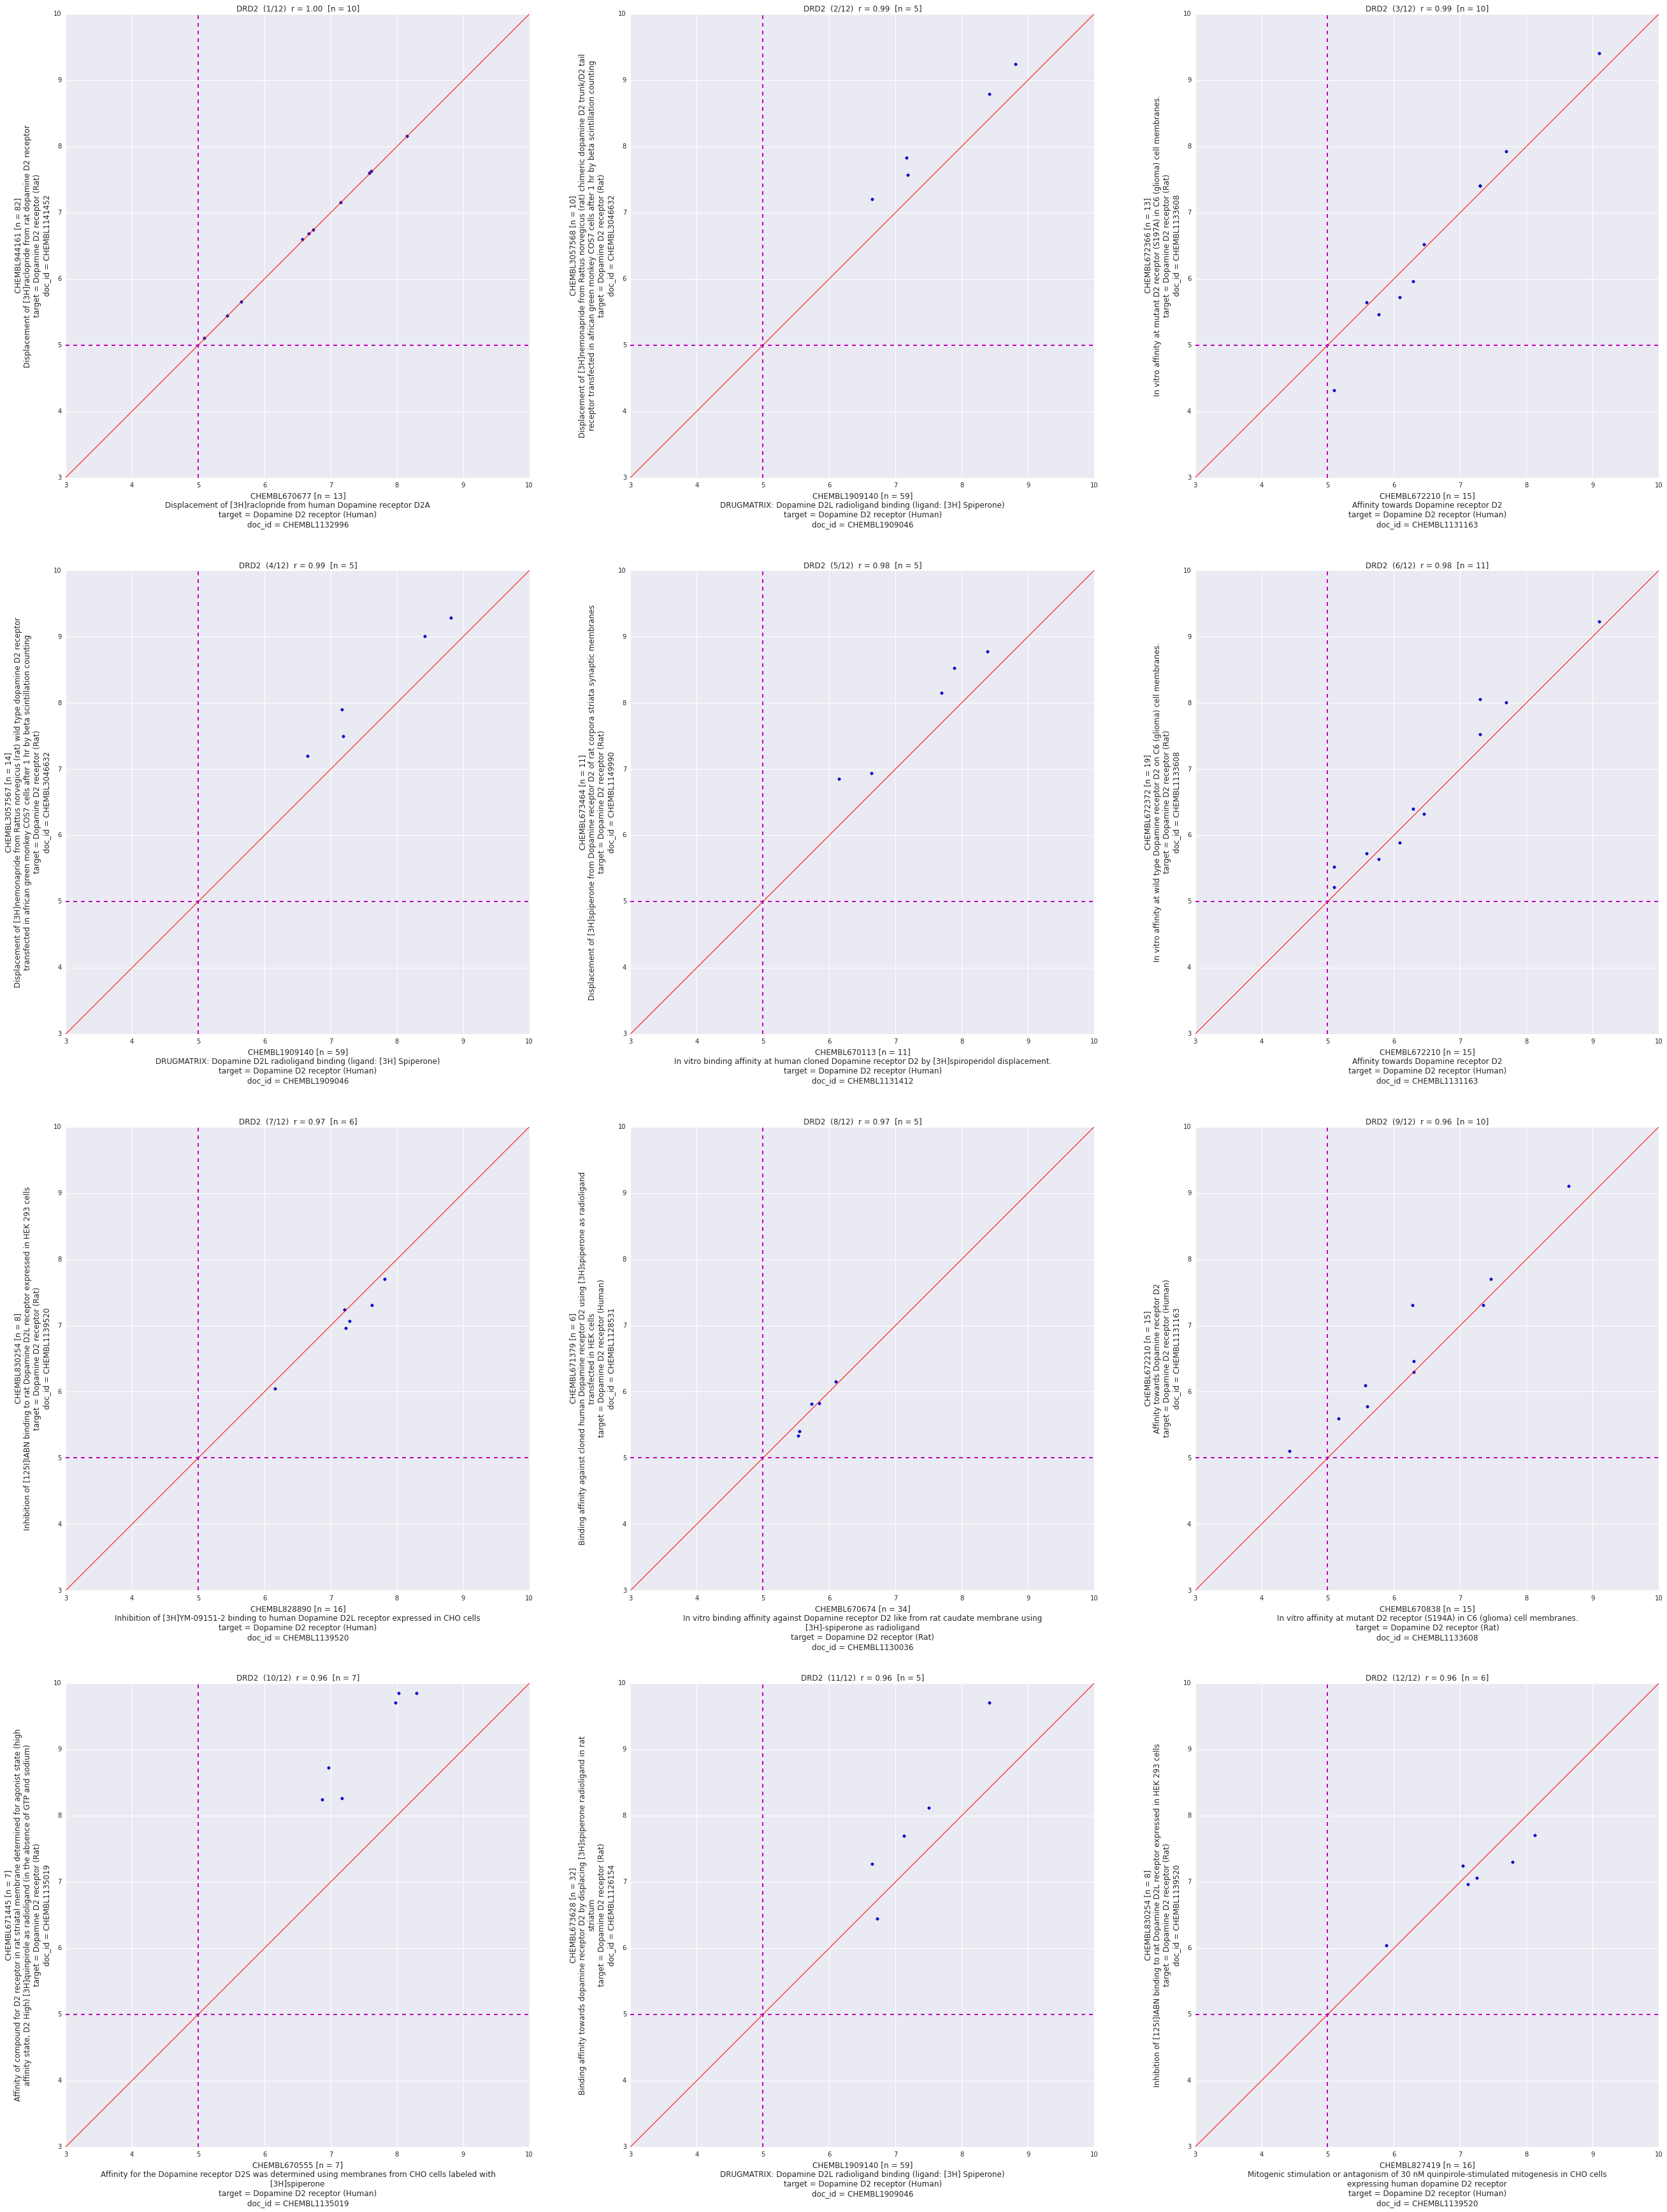

In [22]:
plots_for_assays(subset, means)

In [23]:
HTML(get_html_report(subset))

,assay_chemblid_1,description_1,target_chemblid_1,pref_name_1,species_1,doc_chemblid_1,n_1,assay_chemblid_2,description_2,target_chemblid_2,pref_name_2,species_2,doc_chemblid_2,n_2,n,r,plot
32,CHEMBL670677,Displacement of [3H]raclopride from human Dopamine receptor D2A,CHEMBL217,Dopamine D2 receptor,Human,CHEMBL1132996,13,CHEMBL944161,Displacement of [3H]raclopride from rat dopamine D2 receptor,CHEMBL339,Dopamine D2 receptor,Rat,CHEMBL1141452,82,10,0.999991,1
59,CHEMBL1909140,DRUGMATRIX: Dopamine D2L radioligand binding (ligand: [3H] Spiperone),CHEMBL217,Dopamine D2 receptor,Human,CHEMBL1909046,59,CHEMBL3057568,Displacement of [3H]nemonapride from Rattus norvegicus (rat) chimeric dopamine D2 trunk/D2 tail receptor transfected in african green monkey COS7 cells after 1 hr by beta scintillation counting,CHEMBL339,Dopamine D2 receptor,Rat,CHEMBL3046632,10,5,0.992798,2
67,CHEMBL672210,Affinity towards Dopamine receptor D2,CHEMBL217,Dopamine D2 receptor,Human,CHEMBL1131163,15,CHEMBL672366,In vitro affinity at mutant D2 receptor (S197A) in C6 (glioma) cell membranes.,CHEMBL339,Dopamine D2 receptor,Rat,CHEMBL1133608,13,10,0.990027,3
81,CHEMBL1909140,DRUGMATRIX: Dopamine D2L radioligand binding (ligand: [3H] Spiperone),CHEMBL217,Dopamine D2 receptor,Human,CHEMBL1909046,59,CHEMBL3057567,Displacement of [3H]nemonapride from Rattus norvegicus (rat) wild type dopamine D2 receptor transfected in african green monkey COS7 cells after 1 hr by beta scintillation counting,CHEMBL339,Dopamine D2 receptor,Rat,CHEMBL3046632,14,5,0.985396,4
85,CHEMBL670113,In vitro binding affinity at human cloned Dopamine receptor D2 by [3H]spiroperidol displacement.,CHEMBL217,Dopamine D2 receptor,Human,CHEMBL1131412,11,CHEMBL673464,Displacement of [3H]spiperone from Dopamine receptor D2 of rat corpora striata synaptic membranes,CHEMBL339,Dopamine D2 receptor,Rat,CHEMBL1149990,11,5,0.982881,5
95,CHEMBL672210,Affinity towards Dopamine receptor D2,CHEMBL217,Dopamine D2 receptor,Human,CHEMBL1131163,15,CHEMBL672372,In vitro affinity at wild type Dopamine receptor D2 on C6 (glioma) cell membranes.,CHEMBL339,Dopamine D2 receptor,Rat,CHEMBL1133608,19,11,0.978839,6
106,CHEMBL828890,Inhibition of [3H]YM-09151-2 binding to human Dopamine D2L receptor expressed in CHO cells,CHEMBL217,Dopamine D2 receptor,Human,CHEMBL1139520,16,CHEMBL830254,Inhibition of [125I]IABN binding to rat Dopamine D2L receptor expressed in HEK 293 cells,CHEMBL339,Dopamine D2 receptor,Rat,CHEMBL1139520,8,6,0.974305,7
107,CHEMBL670674,In vitro binding affinity against Dopamine receptor D2 like from rat caudate membrane using [3H]-spiperone as radioligand,CHEMBL339,Dopamine D2 receptor,Rat,CHEMBL1130036,34,CHEMBL671379,Binding affinity against cloned human Dopamine receptor D2 using [3H]spiperone as radioligand transfected in HEK cells,CHEMBL217,Dopamine D2 receptor,Human,CHEMBL1128531,6,5,0.973614,8
126,CHEMBL670838,In vitro affinity at mutant D2 receptor (S194A) in C6 (glioma) cell membranes.,CHEMBL339,Dopamine D2 receptor,Rat,CHEMBL1133608,15,CHEMBL672210,Affinity towards Dopamine receptor D2,CHEMBL217,Dopamine D2 receptor,Human,CHEMBL1131163,15,10,0.964107,9
135,CHEMBL670555,Affinity for the Dopamine receptor D2S was determined using membranes from CHO cells labeled with [3H]spiperone,CHEMBL217,Dopamine D2 receptor,Human,CHEMBL1135019,7,CHEMBL671445,"Affinity of compound for D2 receptor in rat striatal membrane determined for agonist state (high affinity state, D2 High) [3H]quinpirole as radioligand (in the absence of GTP and sodium)",CHEMBL339,Dopamine D2 receptor,Rat,CHEMBL1135019,7,7,0.959539,10
